In [1]:
import os
import warnings
import datetime
import json

import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from pandas_datareader import data
import mplcursors

In [2]:
# Data
INPUT_SYMBOLS_FILEPATH = "../input_symbols.txt"
SOURCE_ADJCLOSE_MAP = {"quandl": "AdjClose",
                       "yahoo": "Adj Close"}

DATA_SOURCE = "yahoo"
START_DATE = "2020/01/01"
END_DATE = "2021/06/30"

# Pipeline
NUM_SIMULATION_POINTS = 200
DATE_FORMAT = "%Y/%m/%d"
YEAR_TRADING_DAYS = 253.
PERCENTAGE_MULTPLIER = 100.

# Optimizer flags:
SHORTING_ALLOWED = False

# 1. Get data using `pandas_datareader`
See https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-quandl

 * [Quandl](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#quandl) `quandl`
     * Daily financial data (prices of stocks, ETFs etc.) from Quandl. The symbol names consist of two parts: DB name and symbol name. DB names can be all the free ones listed on the Quandl website. Symbol names vary with DB name; for WIKI (US stocks), they are the common ticker symbols, in some other cases (such as FSE) they can be a bit strange. Some sources are also mapped to suitable ISO country codes in the dot suffix style shown above, currently available for [BE, CN, DE, FR, IN, JP, NL, PT, UK, US](https://www.quandl.com/search?query=).
     * As of June 2017, each DB has a different data schema, the coverage in terms of time range is sometimes surprisingly small, and the data quality is not always good.
     
 * [Yahoo](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#yahoo-finance-data) `yahoo`:
     * Retrieve daily stock prices (high, open, close, volu,e and adjusted close). Symbols as in [Yahoo Lookup](https://finance.yahoo.com/lookup)

In [3]:
with open(INPUT_SYMBOLS_FILEPATH) as file:
    symbols_names = [x.rstrip() for x in file.readlines()]

raw_df = data.DataReader(symbols_names, DATA_SOURCE,
                         start=START_DATE, end=END_DATE)

# Compute returns
for symbol in symbols_names:
    raw_df[("Return", symbol)] = raw_df[(SOURCE_ADJCLOSE_MAP[DATA_SOURCE], symbol)].pct_change()
    raw_df[("logReturn", symbol)] = raw_df[("Return", symbol)].apply(lambda x: np.log(1 + x))

## Get latest closing prices

In [4]:
_start_date = datetime.datetime.now() - datetime.timedelta(days=5)
_now_date = datetime.datetime.now()
latest_raw_df = data.DataReader(symbols_names, DATA_SOURCE,
                                start=_start_date.strftime(DATE_FORMAT),
                                end=_now_date.strftime(DATE_FORMAT))
latests_prices_ = latest_raw_df[SOURCE_ADJCLOSE_MAP[DATA_SOURCE]].to_numpy()

latests_prices = np.empty(latests_prices_.shape[1])
latests_prices[:] = np.nan
for i in range(latests_prices_.shape[1]):
    for x in latests_prices_[::-1, i]:
        if not np.isnan(x):
            latests_prices[i] = x

# 2. Compute mean returns and Covariance matrix

In [5]:
returns = raw_df["logReturn"].to_numpy()
mean_returns = np.nanmean(returns, axis=0)

# NaN logic
mask = np.isnan(mean_returns)
leave_out_symbols = np.array(symbols_names)[mask].tolist()
if leave_out_symbols:
    warnings.warn(f"Symbols {leave_out_symbols} will not be considered as no data avialable")
    for x in leave_out_symbols:
        symbols_names.remove(x)

returns = returns[:, ~mask]
mean_returns = mean_returns[~mask]
latests_prices = latests_prices[~mask]

covariance_matrix = np.ma.cov(np.ma.masked_invalid(returns),
                              rowvar=False).filled(np.nan)
correlation_matrix = np.ma.corrcoef(np.ma.masked_invalid(returns),
                                    rowvar=False).filled(np.nan)

# 3. Portfolio and optimization

In [6]:
weights_0 = np.ones(mean_returns.shape[0]) / mean_returns.shape[0]
ones_vec = np.ones_like(weights_0)

def compute_portfolio_return(weights, mean_returns):
    return weights.dot(mean_returns)

def compute_portfolio_variance(weights, covariance_matrix):
    return weights.dot(covariance_matrix).dot(weights)

## Optmization

We aim to:
$$
w_{eff} = argmin (w^{T} \Sigma w)
$$
given

$ w^{T} \mu = \mu^{*}$ and $\sum{w} = 1$

and optionally:
 * No shorting possible: $w > 0$
 

In [7]:
# constraints
constrain_matrix = np.vstack((mean_returns, ones_vec))
bounds = None if SHORTING_ALLOWED else optimize.Bounds(np.zeros_like(ones_vec).T,
                                                       ones_vec.T * np.inf)

frontier_returns = []
frontier_volatilities = []
frontier_sharpe_ratios = []
weights_allocations = []
objs_mus = np.linspace(max(mean_returns.min() * 0.5, -0.01),
                       mean_returns.max(), 100)
for objective_mu in objs_mus:
    linear_constraints = optimize.LinearConstraint(constrain_matrix,
                                                   [objective_mu, 1], [objective_mu, 1])
    solution = optimize.minimize(compute_portfolio_variance, weights_0,
                                 args=(covariance_matrix),
                                 constraints=[linear_constraints],
                                 bounds=bounds,
                                 method="trust-constr", jac="3-point")
    # Save solution
    weights_allocations.append(solution.x)

    portfolio_return = compute_portfolio_return(solution.x, mean_returns) * YEAR_TRADING_DAYS
    portfolio_return_true = np.exp(portfolio_return) - 1
    frontier_returns.append(portfolio_return_true)

    portfolio_variance = compute_portfolio_variance(solution.x, covariance_matrix)
    portfolio_volatility = np.sqrt(portfolio_variance * YEAR_TRADING_DAYS)
    frontier_volatilities.append(portfolio_volatility)

    frontier_sharpe_ratios.append((portfolio_return / portfolio_volatility))

weights_allocations = np.array(weights_allocations)
frontier_returns = np.array(frontier_returns)
frontier_volatilities = np.array(frontier_volatilities)
frontier_sharpe_ratios = np.array(frontier_sharpe_ratios)

# Select solutions:
best_sharperatio_idx = frontier_sharpe_ratios.argmax()
best_volatility_idx = frontier_volatilities.argmin()
best_returns_idx = frontier_returns.argmax()

## Simulation

In [8]:
simulation_points = []
for i in range(weights_allocations.shape[0]):
    for _ in range(NUM_SIMULATION_POINTS):
        weights_ = weights_allocations[i, :] + (np.random.rand(mean_returns.shape[0])) * 0.2
        weights_ /= weights_.sum()
        portfolio_return = compute_portfolio_return(weights_, mean_returns) * YEAR_TRADING_DAYS
        portfolio_return_true = np.exp(portfolio_return) - 1

        portfolio_variance = compute_portfolio_variance(weights_, covariance_matrix)
        portfolio_volatility = np.sqrt(portfolio_variance * YEAR_TRADING_DAYS)

        simulation_points += [[portfolio_volatility, portfolio_return_true,
                               portfolio_return / portfolio_volatility]]

simulation_points = np.array(simulation_points)

## Plot

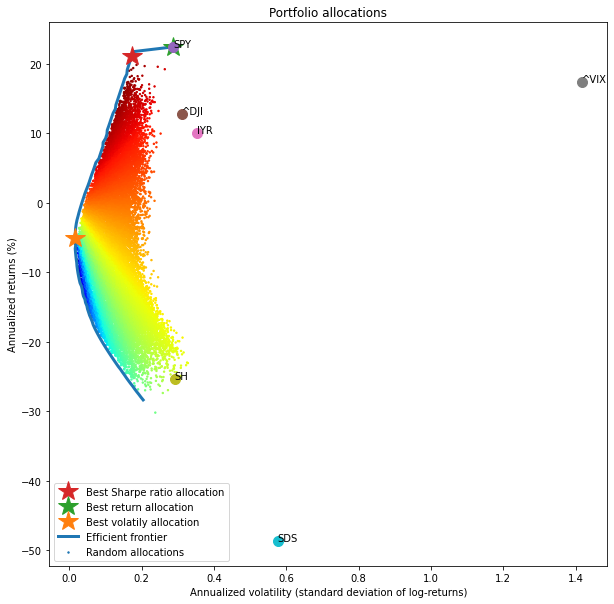

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
plt.scatter(simulation_points[:, 0],
            simulation_points[:, 1] * PERCENTAGE_MULTPLIER,
            s=2, label="Random allocations",
            c=simulation_points[:, 2], cmap='jet')
plt.plot(frontier_volatilities,
         frontier_returns * PERCENTAGE_MULTPLIER,
         label="Efficient frontier", linewidth=3.0)

plt.plot(frontier_volatilities[best_volatility_idx],
         frontier_returns[best_volatility_idx] * PERCENTAGE_MULTPLIER, "*",
         markersize=20, label="Best volatily allocation")

plt.plot(frontier_volatilities[best_returns_idx],
         frontier_returns[best_returns_idx] * PERCENTAGE_MULTPLIER, "*",
         markersize=20, label="Best return allocation")
plt.plot(frontier_volatilities[best_sharperatio_idx],
         frontier_returns[best_sharperatio_idx] * PERCENTAGE_MULTPLIER, "*",
         markersize=20, label="Best Sharpe ratio allocation")

plt.title("Portfolio allocations")
plt.xlabel("Annualized volatility (standard deviation of log-returns)")
plt.ylabel("Annualized returns (%)")

handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
plt.legend(handles, labels)

# plot individual assets
for i, name in enumerate(symbols_names):
    asset_return = (np.exp(mean_returns[i] * YEAR_TRADING_DAYS) - 1) * PERCENTAGE_MULTPLIER
    asset_std = np.sqrt(covariance_matrix[i, i] * YEAR_TRADING_DAYS)
    plt.plot(asset_std, asset_return, "o", markersize=10)
    plt.text(asset_std, asset_return, name)

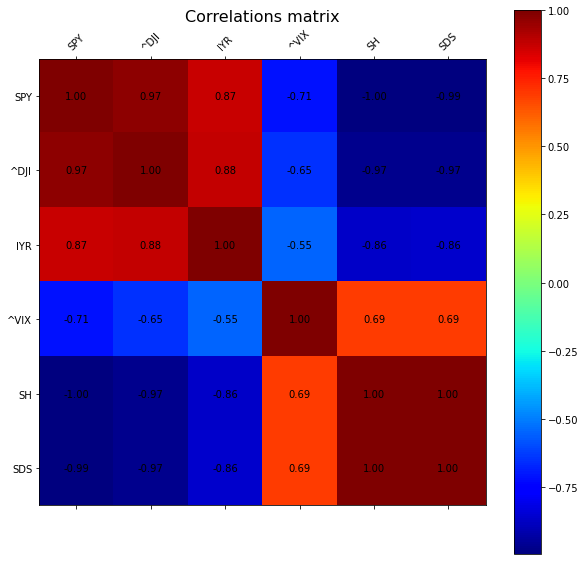

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
plot = ax.matshow(correlation_matrix, cmap="jet")
for (i, j), z in np.ndenumerate(correlation_matrix):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
    
plt.xticks(range(0, len(symbols_names)), symbols_names, rotation=45);
plt.yticks(range(0, len(symbols_names)), symbols_names);
ax.set_title("Correlations matrix", fontsize=16)

fig.colorbar(plot)

In [11]:
best_names = ["best_sharpe_ratio", "best_return", "best_volatility"]
for i, best_index in enumerate([best_sharperatio_idx, best_returns_idx, best_volatility_idx]):
    best_weights = weights_allocations[best_index, :]
    best_solution = dict(zip(symbols_names, best_weights))
    best_solution_dump = json.dumps(best_solution, indent=2)
    print(f"\n\nSolution for {best_names[i]}:")
    print(best_solution_dump)
    print("Expected annual return: ", frontier_returns[best_index] * PERCENTAGE_MULTPLIER, "%")
    print("Expected annual return σ (volatility): ", frontier_volatilities[best_index])
    print("Expected sharpe ratio: ", frontier_sharpe_ratios[best_index])

    with open(f"output_{best_names[i]}_solution.csv", "w") as csvfile:
        w = csv.DictWriter(csvfile, best_solution.keys())
        w.writeheader()
        w.writerow(best_solution)



Solution for best_sharpe_ratio:
{
  "SPY": 0.8539379500208715,
  "^DJI": 0.0015900720343288944,
  "IYR": 0.001639032476679032,
  "^VIX": 0.1342117327833083,
  "SH": 0.0069328606854059515,
  "SDS": 0.001688351999391498
}
Expected annual return:  21.121212993162565 %
Expected annual return σ (volatility):  0.17278041400486036
Expected sharpe ratio:  1.109047107910923


Solution for best_return:
{
  "SPY": 0.9999996474220139,
  "^DJI": 9.625590427763377e-08,
  "IYR": 7.12367098102036e-08,
  "^VIX": 1.8794871551745807e-07,
  "SH": 6.011187927919852e-09,
  "SDS": -1.7695016698323358e-09
}
Expected annual return:  22.440107094932404 %
Expected annual return σ (volatility):  0.28696335988281463
Expected sharpe ratio:  0.7054970461879493


Solution for best_volatility:
{
  "SPY": 0.506090617135822,
  "^DJI": 0.026647858757627183,
  "IYR": 0.011063414318207052,
  "^VIX": 0.004875138927573633,
  "SH": 0.3774932160953951,
  "SDS": 0.07382975476537008
}
Expected annual return:  -5.07262459979321